In [1]:
import torch
from datasets import *
from utils import *
import visualizer
import models
import matplotlib.pyplot as plt
import os


In [2]:
NM_model_state_dict = torch.load(
    'noise_models/spiral_DYR-H/0.0/best.pth')
M_model_state_dict = torch.load(
    'noise_models/spiral_M-DYR-H/0.0/best.pth')
LRM_model_state_dict = torch.load(
    'noise_models/spiral_LRM-DYR-H/0.0/best.pth')


In [3]:
NM_model = models.SpiralModel()
NM_model.load_state_dict(M_model_state_dict)
M_model = models.SpiralModel()
M_model.load_state_dict(M_model_state_dict)
LRM_model = models.SpiralModel()
LRM_model.load_state_dict(LRM_model_state_dict)


<All keys matched successfully>

In [4]:
trainset, trainset_track, _ = get_spiral_datasets("datasets")

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=len(trainset), shuffle=False, num_workers=1, pin_memory=True)
train_loader_track = torch.utils.data.DataLoader(
    trainset_track, batch_size=len(trainset), shuffle=False, num_workers=1, pin_memory=True)

In [5]:
NOISE_LEVEL = 0

labels = get_data_dataset_2(train_loader_track) 

noisy_labels = add_noise_dataset_w(
    train_loader, NOISE_LEVEL, 2)
noisy_labels_track = add_noise_dataset_w(
    train_loader_track, NOISE_LEVEL, 2)

In [6]:
x_train, y_train = next(iter(train_loader))

/home/masonwang/anaconda3/envs/lnoise-analysis/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/cuda/CUDAFunctions.cpp:115.)
  return torch._C._cuda_getDeviceCount() > 0


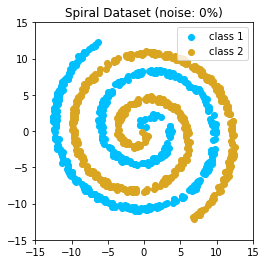

0.501


In [7]:
visualizer.plot_spiral_dataset(x_train, y_train, f'Spiral Dataset (noise: {NOISE_LEVEL}%)')
print(list(y_train).count(0) / len(y_train))

/home/masonwang/latent-mixup-LNL-analysis/visualizer.py:95: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolormesh(x, y, confidence)  # vmin=0, vmax=1


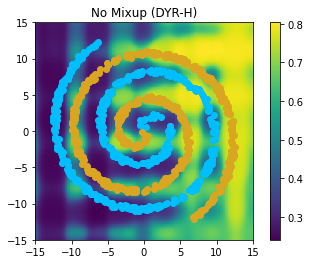

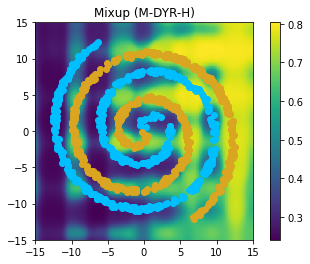

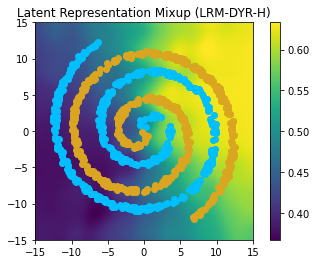

In [8]:
plt.figure(1)
visualizer.plot_spiral_model_confidence(NM_model, x_train, y_train, 'No Mixup (DYR-H)')
plt.figure(2)
visualizer.plot_spiral_model_confidence(M_model, x_train, y_train, 'Mixup (M-DYR-H)')
plt.figure(3)
visualizer.plot_spiral_model_confidence(LRM_model, x_train, y_train, 'Latent Representation Mixup (LRM-DYR-H)')

In [9]:
def demo_all_spiral(noise_levels, model_names, save_fig=False, save_fig_final=False):
    fig, axs = plt.subplots(len(model_names), len(
        noise_levels), figsize=(15, 15))
    for r, model_name in enumerate(model_names):
        for c, noise_level in enumerate(noise_levels):
            axs[r, c].set_title(f'{model_name} (noise={noise_level}%)')
            axs[r, c].set_aspect('equal')
            # axs[r, c].set_xticks([])
            # axs[r, c].set_yticks([])
            # axs[r, c].set_xticklabels([])
            # axs[r, c].set_yticklabels([])

            # get model
            model_state_dict_path = os.path.join('noise_models', 'spiral_{0}'.format(model_name), str(noise_level) + '.0', 'best.pth')
            model_state_dict = torch.load(model_state_dict_path)
            model = models.SpiralModel()
            model.load_state_dict(model_state_dict)

            # get data
            trainset, trainset_track, _ = get_spiral_datasets("datasets")
            train_loader = torch.utils.data.DataLoader(
                trainset, batch_size=len(trainset), shuffle=True, num_workers=1, pin_memory=True)
            train_loader_track = torch.utils.data.DataLoader(
                trainset_track, batch_size=len(trainset), shuffle=False, num_workers=1, pin_memory=True)

            # inject noise
            labels = get_data_dataset_2(train_loader_track)

            noisy_labels = add_noise_dataset_w(
                train_loader, noise_level, 2)
            noisy_labels_track = add_noise_dataset_w(
                train_loader_track, noise_level, 2)

            x_train, y_train = next(iter(train_loader))
            
            visualizer.plot_spiral_model_confidence(
                model, x_train, y_train, ax=axs[r, c])

    # plt.subplots_adjust(wspace=0.25, hspace=-0.1)
    
    if save_fig_final:
        plt.savefig(os.path.join('results', 'spiral_demo.pdf'))
    elif save_fig:
        plt.savefig(os.path.join("results", 'spiral_demo.png'), dpi=300)
    
    plt.show()


/home/masonwang/latent-mixup-LNL-analysis/visualizer.py:92: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(x, y, confidence)


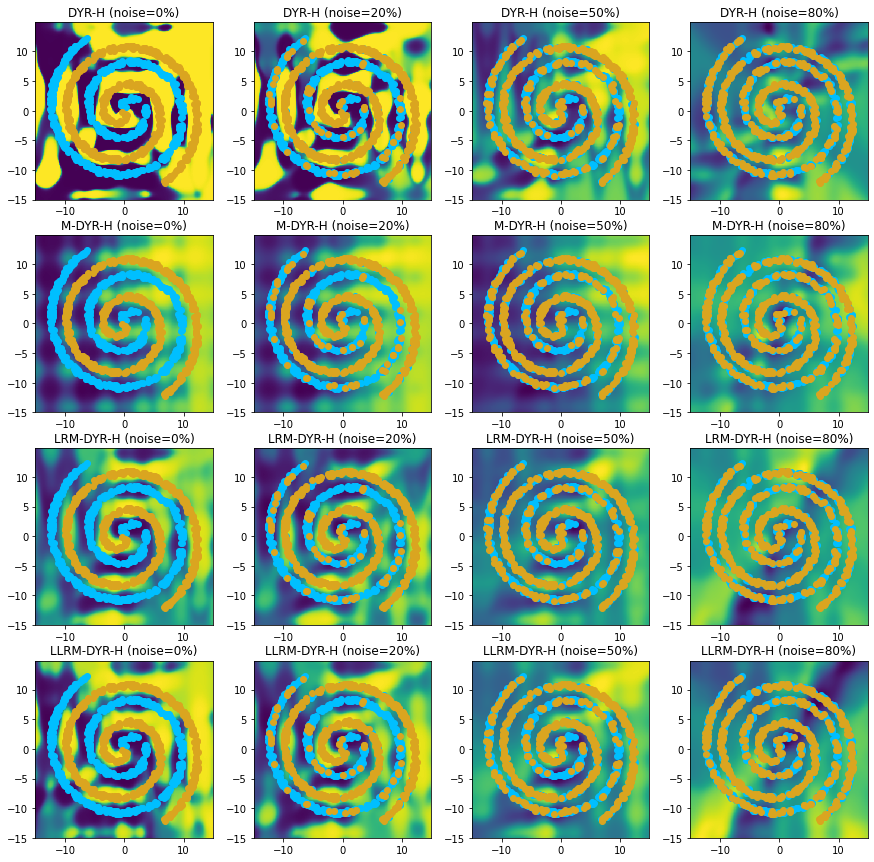

In [10]:
noise_levels = [0, 20, 50, 80] # [0]
model_names = ["DYR-H", "M-DYR-H", "LRM-DYR-H", "LLRM-DYR-H"] # ["DYR-H", "M-DYR-H"] 
demo_all_spiral(noise_levels, model_names)